### Sources: 

- Tutorial: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- Another tutorial: https://markroxor.github.io/gensim/static/notebooks/lda_training_tips.html
    - This tutorial has a few useful links inside
- LDA model reference: https://radimrehurek.com/gensim/models/ldamulticore.html
- LDA coherence model reference: https://radimrehurek.com/gensim/models/coherencemodel.html
- Coherence metrics research paper: http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf

In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [104]:
import re
import os
import gc
import time
import pickle
import numpy as np
import pandas as pd
from pprint import pprint
from importlib import reload

import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
# import nltk
# nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

In [ ]:
# Install gensim if necessary
#!pip install --upgrade gensim 

In [27]:
# import gensim tools
from gensim.utils import simple_preprocess
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from gensim.models import LdaMulticore
from gensim.models import CoherenceModel

In [8]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [11]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

## Load the data

In [3]:
main_dir = '/tf/notebooks/'

In [4]:
outdata_path = main_dir + 'final-project/Classification/data'

In [5]:
with open(os.path.join(outdata_path, 'train_list'), 'rb') as fp:
    main_data = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_ids'), 'rb') as fp:
    main_ids = pickle.load(fp)
with open(os.path.join(outdata_path, 'train_target'), 'rb') as fp:
    main_target = pickle.load(fp)

## Preprocess speech

In [43]:
stop_words = stopwords.words('english')
stop_words.extend(['mr', 'senator', 'united', 'states', 'president', 'would', 'speaker', 'senate'])

In [44]:
def lemmatize_speech(speech):
    processed_speech = []
    for word in simple_preprocess(speech) :
        if word not in stop_words:
            processed_speech.append(WordNetLemmatizer().lemmatize(word, pos='v'))

    return processed_speech

In [45]:
def preprocess_speech(speeches):
    
    speeches_processed = [lemmatize_speech(speech) for speech in speeches]
    
    bigram = Phrases(sentences=speeches_processed, 
                     min_count=5, 
                     threshold=100)
    
    trigram = Phrases(sentences=bigram[speeches_processed], 
                      min_count=5, 
                      threshold=100)  
    
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)
    
    return [trigram_mod[bigram_mod[speech]] for speech in speeches_processed]

In [46]:
start_time = time.time()
data_preprocessed = preprocess_speech(main_data)
print("\nIt took {:.1f} seconds to process the data".format(time.time()-start_time))


It took 22.8 seconds to process the data


In [94]:
word_index = Dictionary(data_preprocessed)
word_index_check = Dictionary(data_preprocessed)
word_index.filter_extremes(no_below=10, no_above=0.3)
print("Number of tokens removed: {}. {} tokens will be used".format(len(word_index_check) - len(word_index), len(word_index)))

Number of tokens removed: 28323. 4622 tokens will be used


In [95]:
most_frequent = sorted(word_index.dfs.items(), key=lambda x: -x[1])[:20]
print("Most frequent words:")
for i in most_frequent:
    print(word_index[i[0]], i[1])

Most frequent words:
bill 967
support 963
take 908
committee 896
years 894
us 893
go 885
say 873
work 866
many 846
today 844
think 842
also 823
like 821
house 817
congress 813
chairman 803
provide 787
need 767
know 753


In [96]:
bow_corpus = [word_index.doc2bow(speech) for speech in data_preprocessed]

In [97]:
print("Individual speech check:")
check = sorted(bow_corpus[100], key=lambda x: -x[1])
for i in range(min(len(check),10)):
    print("Word {} (\"{}\") appears {} time(s).".format(check[i][0], 
                                                     word_index[check[i][0]], 
                                                     check[i][1]))

Individual speech check:
Word 1567 ("promote") appears 7 time(s).
Word 63 ("things") appears 6 time(s).
Word 914 ("issue") appears 6 time(s).
Word 64 ("think") appears 5 time(s).
Word 31 ("house") appears 4 time(s).
Word 379 ("save") appears 4 time(s).
Word 1279 ("bond") appears 4 time(s).
Word 28 ("go") appears 3 time(s).
Word 56 ("say") appears 3 time(s).
Word 224 ("government") appears 3 time(s).


## LDA model

### Picking the number of topics

In [99]:
# topics_range specifies number of topics ranges to test
lda_params = {
    'topics_range': range(2,40,2),
    'chunksize': 100,
    'passes': 20,
    'iterations': 20,
    'eval_every': None,
    'workers': 2,
    'random_state': 100,
    'per_word_topics': False,
    'coherence': 'c_v'
}

In [113]:
def compute_coherence_values(dictionary, corpus, speeches, 
                            topics_range = range(1,10,1),
                            chunksize=100,
                            passes=10,
                            iterations=10,
                            eval_every=None,
                            workers=2,
                            random_state=100,
                            per_word_topics=False,
                            coherence='c_v'):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    model_list, coherence_values = [], []

    for num_topics in topics_range:
        model = LdaMulticore(corpus=corpus,
                             id2word=dictionary,
                             num_topics=num_topics, 
                             chunksize=chunksize,
                             passes=passes,
                             iterations=iterations,
                             eval_every=eval_every,
                             workers=workers,
                             random_state=random_state,
                             per_word_topics=per_word_topics)
        
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, 
                                         texts=speeches, 
                                         dictionary=dictionary, 
                                         coherence=coherence)
        
        cv = coherence_model.get_coherence()
        coherence_values.append(cv)
        print("Coherence for {} topics is {:.2f}".format(num_topics, cv))

    return model_list, coherence_values

In [114]:
%time model_list, coherence_values = compute_coherence_values(dictionary=word_index, corpus=bow_corpus, speeches=data_preprocessed, **lda_params)

Finished LDA for 2 topics
Coherence for 2 topics is 0.37
Finished LDA for 4 topics
Coherence for 4 topics is 0.40
Finished LDA for 6 topics
Coherence for 6 topics is 0.46
Finished LDA for 8 topics
Coherence for 8 topics is 0.44
Finished LDA for 10 topics
Coherence for 10 topics is 0.48
Finished LDA for 12 topics
Coherence for 12 topics is 0.50
Finished LDA for 14 topics
Coherence for 14 topics is 0.46
Finished LDA for 16 topics
Coherence for 16 topics is 0.46
Finished LDA for 18 topics
Coherence for 18 topics is 0.47
Finished LDA for 20 topics
Coherence for 20 topics is 0.44
Finished LDA for 22 topics
Coherence for 22 topics is 0.44
Finished LDA for 24 topics
Coherence for 24 topics is 0.47
Finished LDA for 26 topics
Coherence for 26 topics is 0.46
Finished LDA for 28 topics
Coherence for 28 topics is 0.43
Finished LDA for 30 topics
Coherence for 30 topics is 0.42
Finished LDA for 32 topics
Coherence for 32 topics is 0.44
Finished LDA for 34 topics
Coherence for 34 topics is 0.44
Finis

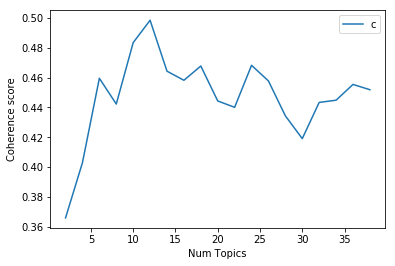

In [115]:
x = lda_params['topics_range']
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Pick the model based on the highest coherence value

In [118]:
# alternatively, pick a number of topics were the score starts to flatten out
num_topics = list(lda_params['topics_range'])[np.argmax(coherence_values)]
optimal_model = model_list[np.argmax(coherence_values)]

In [129]:
# number of words per topic to display (can be any number within vocabulary size)
num_words = 10
top_topics = optimal_model.top_topics(corpus=bow_corpus, 
                                      texts=data_preprocessed,
                                      coherence=lda_params['coherence'], 
                                      topn=num_words)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)
pprint(top_topics)

Average topic coherence: 0.5512.
[([(0.043567196, 'defense'),
   (0.025677465, 'military'),
   (0.024918953, 'arm'),
   (0.014024991, 'nuclear'),
   (0.012702031, 'force'),
   (0.010622187, 'security'),
   (0.008375348, 'aircraft'),
   (0.0071074055, 'weapons'),
   (0.0070584887, 'strategic'),
   (0.006676709, 'must')],
  0.7334587837592823),
 ([(0.035327453, 'budget'),
   (0.028354025, 'tax'),
   (0.019736348, 'billion'),
   (0.01870228, 'cut'),
   (0.01565298, 'percent'),
   (0.014587059, 'increase'),
   (0.014322598, 'spend'),
   (0.012709231, 'year'),
   (0.012372468, 'program'),
   (0.010558332, 'federal')],
  0.6686538163011398),
 ([(0.047873456, 'benefit'),
   (0.032219175, 'social_security'),
   (0.030723514, 'veterans'),
   (0.025986213, 'service'),
   (0.025632817, 'pay'),
   (0.017189408, 'elderly'),
   (0.016738096, 'employees'),
   (0.01629803, 'retire'),
   (0.016189791, 'receive'),
   (0.012604101, 'health')],
  0.6436194626358426),
 ([(0.027453482, 'go'),
   (0.02645531

In [127]:
def get_topics_keywords_dict(ldamodel, num_topics):
    topic_dict = {}
    for i in range(num_topics):
        topic_dict[i] = [word[0] for word in ldamodel.show_topic(i)]
    return topic_dict
keywords_dict = get_topics_keywords_dict(optimal_model, num_topics)

### Append primary and secondary topics to the speech file

In [136]:
def append_topic(ldamodel, corpus, speeches, ids, kw_dict):
    # Init output
    speech_topics_df = pd.DataFrame()
    
    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        sorted_topics = sorted(row, key=lambda x: -x[1])
        topic_count = len(sorted_topics)
        
        topic1_num, topic1_contrib = sorted_topics[0]
        topic1_keywords = ','.join(kw_dict[topic1_num])
        
        if topic_count > 1:
            topic2_num, topic2_contrib = sorted_topics[1]
        else:
            topic2_num, topic2_contrib = -1, 0
        
        new_row = [topic_count, int(topic1_num), round(topic1_contrib,2), topic1_keywords, int(topic2_num), round(topic2_contrib,2)]
        speech_topics_df = speech_topics_df.append(pd.Series(new_row), ignore_index=True)

    speech_topics_df = pd.concat([speech_topics_df, pd.Series(ids)], axis=1)
    speech_topics_df.columns = ['Topic_Count', 'Prim_Topic', 'Prim_Topic_Contrib', 'Prim_Topic_Keywords', 'Sec_Topic', 'Sec_Topic_Contrib', 'Speech_id']
    
    return speech_topics_df


all_speeches_topics_df = append_topic(ldamodel=optimal_model, 
                                      corpus=bow_corpus, 
                                      speeches=data_preprocessed, 
                                      ids=main_ids,
                                      kw_dict=keywords_dict)
all_speeches_topics_df.shape

(3244, 7)

In [138]:
all_speeches_topics_df.head()

,Topic_Count,Prim_Topic,Prim_Topic_Contrib,Prim_Topic_Keywords,Sec_Topic,Sec_Topic_Contrib,Speech_id
0,3.0,2.0,0.84,"go,say,think,amendment,get,want,gentleman,know...",9.0,0.13,970228387
1,6.0,11.0,0.51,"years,us,great,live,work,many,day,know,world,t...",7.0,0.30,970020112
2,2.0,2.0,0.65,"go,say,think,amendment,get,want,gentleman,know...",4.0,0.32,970222405
3,3.0,2.0,0.74,"go,say,think,amendment,get,want,gentleman,know...",6.0,0.18,970192743
4,5.0,10.0,0.34,"program,provide,federal,support,bill,need,fund...",8.0,0.32,970005171


### Pick one speech per document with the highest score

In [141]:
# Selecting n top speeches per topic
top_speeches = 1
top_speeches_df = pd.DataFrame()

all_speeches_topics_df_grpd = all_speeches_topics_df.groupby('Prim_Topic')

for i, grp in all_speeches_topics_df_grpd:
    top_speeches_df = pd.concat([top_speeches_df, grp.sort_values(by='Prim_Topic_Contrib', ascending=False).head(top_speeches)], axis=0)

top_speeches_df.reset_index(drop=True, inplace=True)

In [142]:
for i in range(top_speeches_df.shape[0]):
    print("Topic number: ", top_speeches_df.Prim_Topic[i])
    print("Topic contribution: {:.2f}".format(top_speeches_df.Prim_Topic_Contrib[i]))
    print("Keywords: \n", top_speeches_df.Prim_Topic_Keywords[i])
    print("Speech: \n", main_data[main_ids.index(top_speeches_df.Speech_id[i])])
    print("-"*50)

Topic number:  0.0
Topic contribution: 0.80
Keywords: 
 price,market,company,percent,industry,interest,american,cost,farm,trade
Speech: 
 Mr. Chairman. I C rise in opposition to the amendment. 0 Mr. Chairman. I support H.R. 5133. t the Fair Practices Automotive Products Act of 1982. Simply stated. what this bill is about Is helping the U.S. auto industry. For the past 4 years. the industry has been sinking deeper and deeper into depression. Total sales are less than half their 1978 level and almost 1 million workers have lost their jobs. including 280.000 auto workers and another 670.000 workers in auto supply industries. At the same time. sales of imported cars have been rising. Imports from Japan have increased by over 37 percent. and more than 1 of every 5 cars sold in the United States is Japanese built. Overall. imports make up 27 percent of the U.S. car market. We cant continue to allow imports to take a larger share of our market. with the result of lost American Jobs and an- ev

### Primary and secondary topic distribution in the speech file

In [145]:
topics_df = pd.DataFrame(index=range(num_topics))
# Number of Documents for Each Topic
prim_topic_counts = all_speeches_topics_df['Prim_Topic'].value_counts().sort_index()
sec_topic_counts = all_speeches_topics_df['Sec_Topic'].value_counts().sort_index()
# Percentage of Documents for Each Topic
prim_topic_share = round(prim_topic_counts/len(main_data), 2)
prim_topic_share.name = 'Prim_Topic_Contr'
sec_topic_share = round(sec_topic_counts/len(main_data), 2)
sec_topic_share.name = 'Sec_Topic_Contr'

In [146]:
topics_df= topics_df.join(prim_topic_counts)\
                    .join(prim_topic_share)\
                    .join(sec_topic_counts)\
                    .join(sec_topic_share)\
                    .join(pd.DataFrame.from_dict(keywords_dict, orient='index'))
topics_df.reset_index(inplace=True)
topics_df.columns = ['Topic_Num', "Prim_Cnt", "Prim_Share", "Sec_Cnt", "Sec_Share"] + ['kw'+str(i) for i in range(num_words)]
topics_df.Prim_Cnt.sum(), topics_df.Prim_Share.sum(), topics_df.Sec_Cnt.sum(), topics_df.Sec_Share.sum()

(3244, 1.0, 3193, 0.9900000000000001)

In [147]:
topics_df.sort_values(by='Prim_Cnt', ascending=False)

,Topic_Num,Prim_Cnt,Prim_Share,Sec_Cnt,Sec_Share,kw0,kw1,kw2,kw3,kw4,kw5,kw6,kw7,kw8,kw9
2,2,852,0.26,494,0.15,go,say,think,amendment,get,want,gentleman,know,us,come
9,9,570,0.18,477,0.15,committee,bill,amendment,house,act,provision,congress,legislation,vote,report
11,11,430,0.13,327,0.10,years,us,great,live,work,many,day,know,world,today
10,10,349,0.11,352,0.11,program,provide,federal,support,bill,need,fund,legislation,act,work
6,6,280,0.09,269,0.08,budget,tax,billion,cut,percent,increase,spend,year,program,federal
5,5,185,0.06,252,0.08,school,serve,service,national,community,public,education,state,article,years
7,7,176,0.05,332,0.10,international,government,world,nations,resolution,american,policy,support,must,concern
0,0,126,0.04,149,0.05,price,market,company,percent,industry,interest,american,cost,farm,trade
4,4,82,0.03,151,0.05,energy,project,cost,million,construction,job,need,study,percent,build
3,3,81,0.02,140,0.04,defense,military,arm,nuclear,force,security,aircraft,weapons,strategic,must
